# TensorFlow Data Pipeline, Mini DenseNet ve GradCAM | Part 1 - 2 - 3

## Bölümler
#### Part 1
* Kütüphaneler

* Veri Yükleme
 * `tf.data.Dataset.list_files()` kullanarak.


* Ön İşleme ve Resimleri Augment Etme
 * `tf.data` pipeline'ı oluşturup, `tf.image` ve `tfa.image` kullanarak farklı dönüşümler uygulamak.

#### Part 2
* Modeli Oluşturmak
 * Mini DenseNet ve Layer Subclassing kullanmak
 * Modeli custom training loop kullanarak eğitmek

* Loss ve Accuracy Eğrilerini Plot Etmek
 * Training loop kullanarak toplanan loss ve accuracy değerlerini plot edip görmek

* Modelin performansını görmek için confusion matrix ve classification report kullanmak


#### Part 3
* Gradient-weighted Class Activation Mapping (GradCAM)
 * Grad-CAM ve Şehir Efsanesi Olay
 * GradCAM Nedir?
 * GradCAM'i test setinde denemek

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Kütüphaneler

In [2]:
!pip install tensorflow-addons
!pip install keras==2.12
!pip install tensorflow==2.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 30.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.12.0 which is incompatib

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout, \
                                    BatchNormalization, Conv2D, \
                                    MaxPooling2D, Concatenate, AveragePooling2D

import matplotlib.pyplot as plt

import os
import numpy as np

import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import PIL
import glob
import pathlib

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

print('TF Version:', tf.__version__)
print('TFA Version:', tfa.__version__)

TF Version: 2.12.0
TFA Version: 0.23.0


## Veri Yükleme

In [2]:
# prompt: unrar ile /content/ e çıkarma kodu

!unrar x "/content/drive/MyDrive/Datasetler/Sebze.rar" "/content/"


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/Sebze/train/Papaya/0006.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0007.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0008.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0009.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0010.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0011.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0012.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0013.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0014.jpg                          76%  OK 
Extracting  /content/Sebze/train/Papaya/0015.jpg                          76%  OK 
Extracting  /content/Sebze/train/

In [3]:
# Train ve Test klasörlerinin sırasıyla isimleri.
train_dir = "/content/Sebze/train"
test_dir = "/content/Sebze/test"

In [4]:
# Her ana klasör kendi için alt sınıf klasörlerine ayrıldığı için
# iki kere /* ekliyoruz. Böylece tüm resimleri almış olacağız.
train_dir_list = train_dir + '/*/*'
test_dir_list = test_dir + '/*/*'
train_dir_list, test_dir_list

('/content/Sebze/train/*/*', '/content/Sebze/test/*/*')

In [5]:
# Dataset boyutunu direkt olarak görebilmek için
# bir fonksiyon yazıyoruz.
def data_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

In [6]:
# list_files bir tf.data olup, glob patterni eşleşen tüm dosyaları alacaktır.
list_ds_train = tf.data.Dataset.list_files(train_dir_list,
                                     shuffle = False)

list_ds_test = tf.data.Dataset.list_files(test_dir_list,
                                     shuffle = False)

list_ds_train = list_ds_train.shuffle(data_size(list_ds_train),
                                     reshuffle_each_iteration = False)

list_ds_test = list_ds_test.shuffle(data_size(list_ds_test),
                                     reshuffle_each_iteration = False)

# Datasetlerden birer tane örnek al.
for files in list_ds_train.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_train\mountain\2174.jpg

for files in list_ds_test.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_test\mountain\24204.jpg

# Datasetlerin boyutuna bak.
total_images = data_size(list_ds_train)
print('\nEğitim setinde %d resim var' %(total_images)) # 14034

total_test = data_size(list_ds_test)
print('\nTest setinde %d resim var' %(total_test)) # 3000

/content/Sebze/train/Cucumber/0150.jpg
/content/Sebze/test/Brinjal/1111.jpg

Eğitim setinde 15000 resim var

Test setinde 3000 resim var


In [7]:
# Sınıf isimlerini dizinden almak için pathlib kullanıyoruz.
data_dir = pathlib.Path(train_dir)

class_names = [files.name for files in data_dir.glob('*/')]

# Alfabetik olarak sırala.
class_names = np.array(sorted(class_names), dtype = 'object')

print(class_names) # ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']

['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


In [8]:
# Train datasından validation set oluşturmak için
# take() ve skip() fonksiyonlarını kullanabiliriz.
val_size = int(total_images * 0.1)

list_ds_val = list_ds_train.take(val_size)
list_ds_train = list_ds_train.skip(val_size)

print('Train:', data_size(list_ds_train)) # 12631
print('Val:', data_size(list_ds_val)) # 1403
print('Test:', data_size(list_ds_test)) # 3000

# Overlap var mı diye kontrol et.
train = []
for x in list_ds_train:
    train.append(x.numpy().decode('utf-8'))

val = []
for x in list_ds_val:
    val.append(x.numpy().decode('utf-8'))

len(set(train).intersection(set(val))) # 0

Train: 13500
Val: 1500
Test: 3000


0

In [9]:
def get_label(files_path):
    # contents tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=string, numpy=
    # array([... b'seg_train', # Son iki string sınıfı ve resmin ismini içeriyor.
    #        b'glacier', b'10.jpg'], dtype=object)>

    contents = tf.strings.split(files_path, os.path.sep)

    # class_idx tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=bool, numpy=array([False, False,
                                        # True, False, False, False])>
    class_idx = contents[-2] == class_names

    # Return: tf.where(class_idx)
    # <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]])>
    # Alternatif olarak tf.argmax(class_idx) kullanabilirdik
    return tf.where(class_idx)[0][0]

def decode_img(image):
    # tf.io.read_file ile okunmuş resimlerin tf.image.decode_jpeg
    # ile decode edilmesi gerekir. Bu sayede resimleri array formatına
    # çevirmiş oluruz. channel=3 diyerek de RGB olduğunu belirtiyoruz.
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def process_path(file_path):
    label = get_label(file_path)

    # img :<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\x0\ ...
    # tf.io.read_file içeriği olduğu gibi okur, onun için decode edilmesi gerekir.
    image = tf.io.read_file(file_path)

    # Şimdi ise resimler artık array formatındadır.
    image = decode_img(image)
    return image, label

In [10]:
# num_parallel_calls ile mapping işlemini parallelize etmiş oluyoruz.
# tf.data.AUTOTUNE, tf.data çalışma zamanı sırasında paralellik düzeyine karar verecektir.

train_ds = list_ds_train.map(process_path,
                             num_parallel_calls=tf.data.AUTOTUNE)

val_ds = list_ds_val.map(process_path,
                         num_parallel_calls=tf.data.AUTOTUNE)

test_ds = list_ds_test.map(process_path,
                           num_parallel_calls=tf.data.AUTOTUNE)

## Process and Augmentation Pipeline

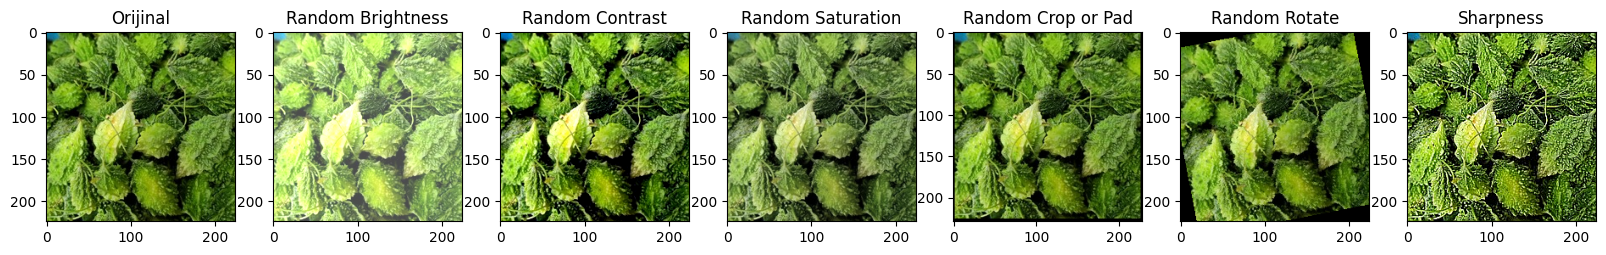

In [11]:
# tf.image ve tfa.image ile resimleri augment edebilir veya üzerlerinde random
# dönüşümler uygulayabiliriz.

for x, y in train_ds.take(1): # Datasetten 1 tane resim ve label çifti alır.
    seed = (52, 2)

    # Burada tf.image ve tfa.image altında olan fonksiyonları göstereceğim.
    # Random dönüşümler için stateless_random_* olanları kullanıyoruz.
    # Farkını aşağıda açıklıyorum.

    random_bright = tf.image.stateless_random_brightness(x, max_delta=1.0,
                                                       seed = seed)

    random_contrast = tf.image.stateless_random_contrast(x, 0.2, 2.0,
                                                       seed = seed)

    random_saturation = tf.image.stateless_random_saturation(x, 0.2, 1.0,
                                                           seed = seed)

    random_crop_or_pad = tf.image.resize_with_crop_or_pad(x,
                               tf.shape(x).numpy()[0] + 5,
                               tf.shape(x).numpy()[1] + 5)

    random_rotate = tfa.image.rotate(x, tf.constant(tf.random.uniform((1,),
                                                        minval = 0.01,
                                                        maxval = 0.4)))

    sharpness = tfa.image.sharpness(x, 5.1)

    plt.figure(figsize = (20, 12))

    plt.subplot(1, 7, 1)
    plt.imshow(x.numpy() / 255.0)
    plt.title('Orijinal')

    plt.subplot(1, 7, 2)
    plt.imshow(random_bright.numpy() / 255.0)
    plt.title('Random Brightness')

    plt.subplot(1, 7, 3)
    plt.imshow(random_contrast.numpy() / 255.0)
    plt.title('Random Contrast')

    plt.subplot(1, 7, 4)
    plt.imshow(random_saturation.numpy() / 255.0)
    plt.title('Random Saturation')

    plt.subplot(1, 7, 5)
    plt.imshow(random_crop_or_pad.numpy() / 255.0)
    plt.title('Random Crop or Pad')

    plt.subplot(1, 7, 6)
    plt.imshow(random_rotate.numpy() / 255.0)
    plt.title('Random Rotate')

    plt.subplot(1, 7, 7)
    plt.imshow(sharpness.numpy() / 255.0)
    plt.title('Sharpness')

In [12]:
def resize_and_one_hot(image, label):
    # Resimleri float32'ye cast ediyoruz.
    image = tf.cast(image, tf.float32)

    # Resimlerin hepsini 128 x 128 boyutuna getiriyoruz.
    image = tf.image.resize(image, [128, 128])

    # Resimleri normalize edip, labelları one hot encoded şeklinde
    # döndürüyoruz.
    return image / 255.0, tf.one_hot(label, 6)

#### Normal tf.image.random ve tf.stateless_random operasyonları arasındaki fark:
* TensorFlow'da random resim transformasyonları için fonksiyonlar genel olarak iki gruba ayrılır.
  * tf.image.random.* ve
  * tf.image.stateless_random.*


* `tf.image.random` operasyonlarının kullanılması tavsiye edilmez çünkü arka planda TF 1.X'den kalan bazı fonksiyonları kullanırlar. Onun yerine `tf.image.stateless_random` fonksiyonlarını kullanacağız.

In [13]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_one_hot(image,label)

    # Dönüşümleri iki gruba ayıracağız.
    transformation_selection = tf.random.uniform([], minval = 0,
                                                 maxval = 1,
                                                 dtype = tf.float32)

    # İki grubu kendi içinde alt gruplara böleceğiz.

    # 1.gruptaki dönüşümleri uygulama ihtimali
    prob_1 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)

    # 2.gruptaki dönüşümleri uygulama ihtimali
    prob_2 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)

    # Yani her dönüşümün uygulanmak için %25 şansı var.
    # Her resme sadece bir dönüşüm uygulayacağız.
    image = tf.cond(tf.greater(transformation_selection, 0.5),

                    # tf.cond fonksiyonlarının -callable- olmasını istediği
                    # için lambda yazıyoruz.

                    # Eğer ki transformation_selection > 0.5 ise buraya gelecek.
                    # Eğer prob_1 > 0.5 kontrastı değiştir. Değilse parlaklığı değiştir.
                    lambda: tf.cond(tf.greater(prob_1, 0.5),
                            lambda: tf.image.stateless_random_contrast(image, 0.1, 0.5,
                                                     seed = seed),
                            lambda: tf.image.stateless_random_brightness(image, max_delta=0.3,
                                                     seed = seed),
                           ),

                    # Eğer ki transformation_selection < 0.5 ise buraya gelecek.
                    # Eğer prob_2 > 0.5 saturation uygula. Değilse resmi random döndür.
                    lambda: tf.cond(tf.greater(prob_2, 0.5),
                            lambda: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                                           seed = seed),
                            lambda: tfa.image.rotate(image, tf.random.uniform((1,),
                                                        minval = 0.01,
                                                        maxval = 0.2))
                          )
                   )

    #   new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #   Eğer ki tf.cond dışında farklı seed kullanıp farklı dönüşümler uygulamak isterseniz
    #   new_seed'i aşağıdaki gibi fonksiyona geçebilirsiniz.
    """
    Örnek: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                              seed = new_seed)
    """
    return image, label

In [14]:
random_number = tf.random.Generator.from_seed(52222, alg='philox')

# Ana fonksiyonumuz seed alacağı için, bunu başka bir fonksiyonun içine
# koyup, ana fonksiyonumuzu çağırabiliriz.
def augment_wrapper(x, y):
    seed = random_number.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [15]:
# Shuffle ve Prefetch'i aşağıda açıklıyorum.

train_ds = (
    train_ds
    .map(augment_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

# Validasyon ve Test setlerini augment etmiyoruz.
val_ds = (
    val_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

### shuffle() nasıl çalışır?
* Shuffle fonksiyonunu çağırınca buffer_size diye bir parametre veriyoruz. Mesela, datasetimizde 100K element varsa ve size'ı 1000 olarak verirsek, buffer (arabellek) ilk 1000 element ile doldurulacak ve birisi rastgele seçilecek. Bundan sonra ise, tekrar rastgele eleman seçmeden önce bunu 1000 ve ilk elemanla değiştirecek.


### prefetch() nasıl çalışır?
* Prefetch() fonksiyonu model eğitimi ve ön işleme sürecini overlap etmeye yarayan bir fonksiyodundur. Örnek olarak, GPU n. adımdaki gelen resimleri/verileri işleyip hesaplama yaparken, CPU da bir sonraki adımı hazırlıyor olacak.

* Prefetch ile CPU, GPU model eğitimi yaparken boşta durmayacak, sonraki batch'i hazırlıyor olacak.

--> prefetch() olmadan:
![image.png](attachment:image.png)

--> prefetch() ile:
![image-2.png](attachment:image-2.png)

In [16]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [17]:
plt.figure(figsize=(20, 20))
plt.tight_layout()

# tf.data datasetimizi batchlediğimizden ötürü take(1) bütün batch'i döndürür.
# Ondan dolayı içeride bir for açıp batch içinde bulunan resimler arasında dönüyoruz.
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(tf.clip_by_value(images[i], 0, 1).numpy())
        plt.title(class_names[tf.argmax(labels[i], axis = -1)])
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Veya dizinlerden sınıfların dağılımını sayabiliriz.
images_per_class = []
class_name = []
for i in os.listdir('/content/Sebze/train'):
    train_class = os.listdir(os.path.join('/content/Sebze/train', i))
    images_per_class.append(len(train_class))
    class_name.append(i)
    print('Class: {} = Total Images: {} \n'.format(i, len(train_class)))

Class: Broccoli = Total Images: 1000 

Class: Cucumber = Total Images: 1000 

Class: Capsicum = Total Images: 1000 

Class: Carrot = Total Images: 1000 

Class: Bean = Total Images: 1000 

Class: Brinjal = Total Images: 1000 

Class: Bottle_Gourd = Total Images: 1000 

Class: Radish = Total Images: 1000 

Class: Potato = Total Images: 1000 

Class: Cauliflower = Total Images: 1000 

Class: Papaya = Total Images: 1000 

Class: Cabbage = Total Images: 1000 

Class: Pumpkin = Total Images: 1000 

Class: Bitter_Gourd = Total Images: 1000 

Class: Tomato = Total Images: 1000 



## Modeli Oluşturalım
* Modeli Functional API kullanarak yazacağız.

In [19]:
input_shape = (128,128,3)

# Input tensor
input_layer = tf.keras.Input(input_shape)

# 2 Convolutions + BN + Swish Aktivasyonu
x = Conv2D(16, 5)(input_layer)
x = Conv2D(32, 3)(x)
x = BatchNormalization()(x)
x = tf.nn.silu(x) # swish

x_out_1 = MaxPooling2D((3,3))(x) # Normal MaxPooling

# Concatenate --> 2 Conv Layers & Skip Connection
x = Conv2D(32, 3, padding = 'same')(x_out_1)
x = Conv2D(64, 3, padding = 'same')(x)
x = BatchNormalization()(x)
x = tf.nn.silu(x)
residual_1 = tf.keras.layers.Concatenate()([x,x_out_1])

# Bu bağlantıyı görselleştirmek istersek:

![image.png](attachment:image.png)

In [20]:
# Aynı şeyleri yazmak yerine class olarak tanımlayalım.

class SkipConnectionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        # Sınıf değişkenlerini setup ediyoruz.
        super(SkipConnectionLayer, self).__init__()
        self.units = units

    def build(self, units):
        # Layerları ekliyoruz.
        self.conv = Conv2D(self.units,
                                kernel_size= (3, 3),
                                 padding = 'same')

        self.conv2 = Conv2D(self.units,
                               kernel_size= (3, 3),
                               padding = 'same')
        self.bn = BatchNormalization()

    def call(self, inputs, training = False):
        # Forward propagation burada oluyor.

        # Dropout, BatchNorm gibi layerların davranışları train ve test
        # zamanında farklıdır. Modelden prediction alırken bu layerların
        # aktif olmasını istemeyiz. Training, bu davranışı kontrol ediyor.
        x = self.conv(inputs)
        x = self.conv2(x)

        x = self.bn(x, training = training)
        x = tf.nn.silu(x)
        return Concatenate()([x, inputs])

    # get_config'i override ediyoruz, böylece TF modeli
    # kaydederken veya yüklerken sorun yaşamayacak.
    # Kaynak koduna bakıp daha fazla bilgi edinmek isterseniz:
    # https://github.com/tensorflow/tensorflow/blob/cdf2c541c3dd3fb6d03cce4d23fc6c548bc9017c/tensorflow/python/keras/engine/base_layer.py#L539-L594
    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [21]:
# SkipConnection layerlarını subclass olarak ifade ettik.

x = SkipConnectionLayer(64)(residual_1)
x = SkipConnectionLayer(128)(x)
x = SkipConnectionLayer(256)(x)

x = MaxPooling2D((3,3))(x)

x = Conv2D(512, (3,3), padding = 'same',
                                   name = 'last_conv_layer')(x)
x = tf.nn.silu(x)

# Average Pooling
x = AveragePooling2D((2,2), name = 'avg_pool')(x)

# Final layer
x = GlobalMaxPooling2D()(x)
x = Dense(6, activation = 'softmax', name = 'last_dense')(x)
# 6 class ve multi-class classification olduğu için
# softmax aktivasyonu kullandık.

model = tf.keras.Model(inputs = input_layer,
                       outputs = x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 124, 124, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 122, 122, 32  4640        ['conv2d[0][0]']                 
                                )                                                             

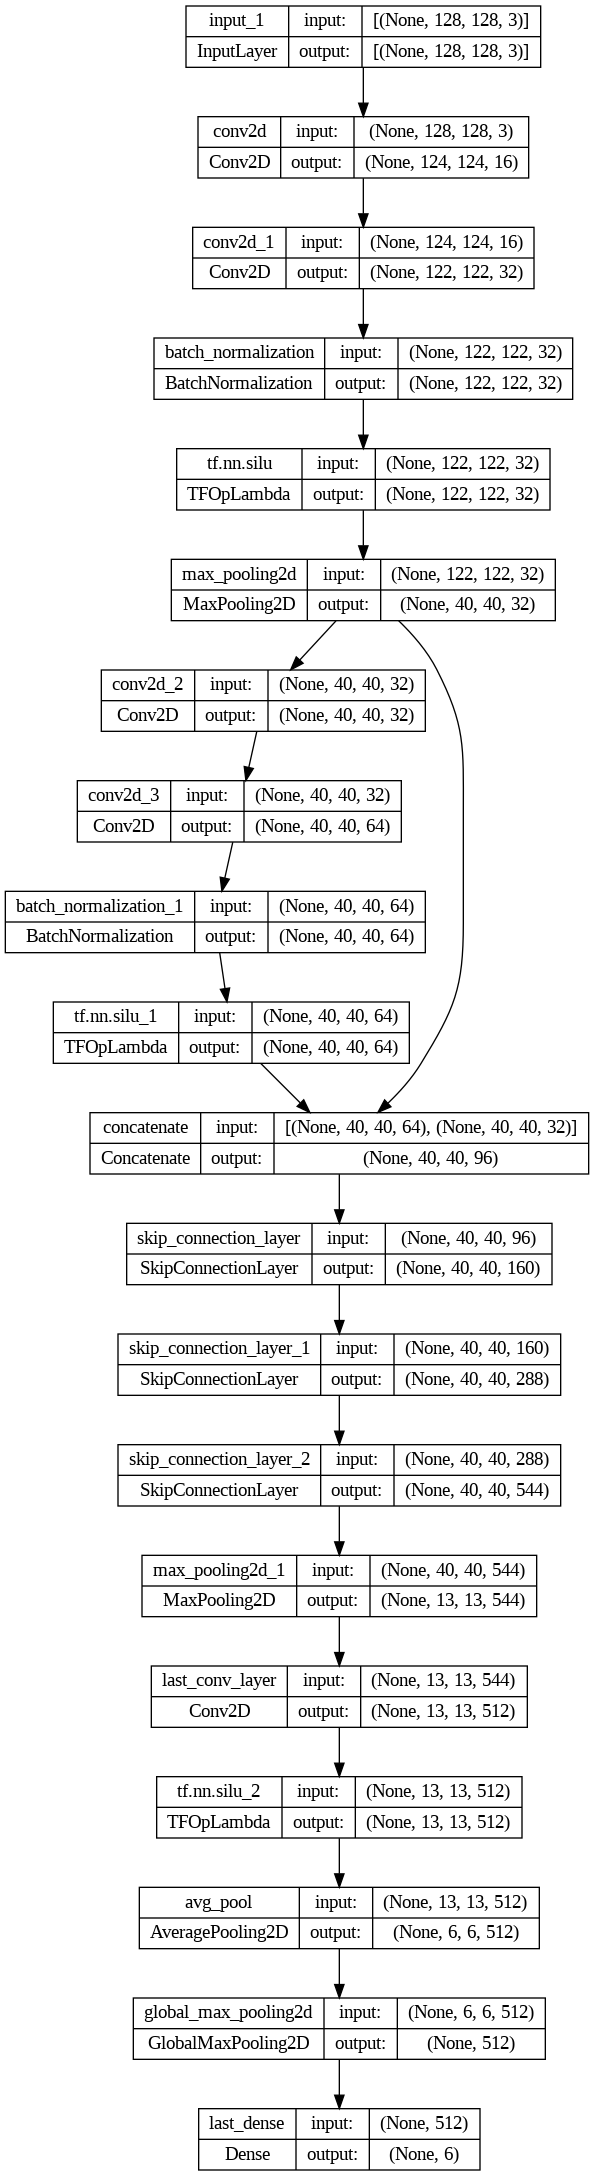

In [22]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [23]:
# RAdam ve Lookahead'i beraber kullanıyoruz.
# Bu şekilde daha stabil bir training süreci elde edeceğiz.

radam = tfa.optimizers.RectifiedAdam(learning_rate = 0.0001)
optimizer = tfa.optimizers.Lookahead(radam, sync_period=4, slow_step_size=0.5)

# Labellar one hot encoded olduğu için CategoricalCrossentropy
# OHE olmasaydı SparseCategoricalCrossentropy
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Metrikler için de aynısı geçerlidir.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
loss_fn

#### tf.function
* Hesaplama açısından maliyetli olan görevlerde `@tf.function` dekoratörü kullanıyoruz. Bu şekilde dekore edilmiş fonksiyonlar çağrılabilir bir TensorFlow graphına dönüşecektir. Böylece, eager execution yapmak yerine daha hızlı olan **graph execution** kullanıyor olacağız.

<br>

#### train_step(x, y)
* Her batch için bir GradientTape() scope'u açıyoruz.
* Bu scope içinde modele forward pass yapıp loss hesaplıyoruz.
* Loss hesabından sonra scope dışında, ağırlıkların loss fonksiyonuna göre gradyanlarını alıyoruz.
* Ondan sonra optimizer'ımızı kullanarak ağırlıkları, gradyanlara dayalı olarak güncelliyoruz.
* En son ise metrik güncelliyoruz ve o batch'in loss değerini döndürüyoruz.

In [24]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss_value = loss_fn(y, preds)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, preds)
    return loss_value

#### val_step(x, y)
* `train_step` fonksiyonu ile benzerdir. Bu sefer sadece forward pass yapıp loss hesaplıyoruz.
* `training = False` olmasının sebebi, BatchNorm - Dropout gibi layerların tahmin alırken aktif olmasını istemiyor oluşumuz. Ondan dolayı `False` dedik.

In [25]:
@tf.function
def val_step(x, y):
    val_preds = model(x, training=False)
    val_loss = loss_fn(y, val_preds)
    val_acc_metric.update_state(y, val_preds)
    return val_loss

In [26]:
data_size(train_ds)

422

In [27]:
epochs = 30

train_acc_per_epoch = []
val_acc_per_epoch = []

train_mean_loss = [] # Her epoch'un ortalaması
validation_mean_loss = [] # Her epoch'un ortalaması

for epoch in range(epochs):
    # train_loss ve val_loss listelerini batchlerin loss değerlerini tutmak
    # için kullanacağız. Ondan dolayı her epochta sıfırlıyoruz.
    train_loss = []
    validation_loss = []

    print("\nIn epoch %d" % (epoch,))
    start_time = time.time()

    # Datasetin batchleri üzerinde iterate ediyoruz.
    for step, (x_train_batch, y_train_batch) in enumerate(train_ds):
       # Boş batch'leri atlamak için kontrol
        if len(x_train_batch) == 0 or len(y_train_batch) == 0:
          print(f"Step {step}: Boş bir batch bulundu, atlanıyor.")
          continue

        train_loss_steps = train_step(x_train_batch, y_train_batch)

        # Her batchin loss değerini listemize ekliyoruz.
        train_loss.append(train_loss_steps.numpy())

        # Her 78 step için bir bilgi print ediyoruz.
        # Step: len(Toplam data) / batch size
        if step % 78 == 0:
            print(
                "Step %d, training loss: %.5f"
                % (step, float(train_loss_steps))
            )

            print("Modelin gördüğü toplam örnek sayısı: %d" % ((step + 1) * 32))

    # Her epoch sonunda metrikleri gösteriyoruz.
    train_acc = train_acc_metric.result()

    print('\nBu epoch için ortalama training loss: %.5f' %(np.mean(train_loss)))
    print('Bu epoch için training accuracy: %.5f' % (float(train_acc)))

    # Metrikleri epoch sonunda resetliyoruz ki üstüne yazmasın.
    train_acc_metric.reset_states()

    # Her epoch sonunda validasyon setimizi predict edelim.
    # Aynı batchler üzerinde ilerleme mantığı burada da geçerli.
    for x_test_batch, y_test_batch in val_ds:
        val_loss_steps = val_step(x_test_batch, y_test_batch)
        validation_loss.append(val_loss_steps.numpy())

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()

    # Ortalama değerleri tutacağımız listeleri güncelliyoruz.
    # Her batchin ortalama değerini alıp listelere ekliyoruz.
    train_mean_loss.append(np.mean(train_loss))
    validation_mean_loss.append(np.mean(validation_loss))

    # Accuracy metriklerini de aynı mantıkla ortalama alarak ekliyoruz.
    train_acc_per_epoch.append(train_acc.numpy())
    val_acc_per_epoch.append(val_acc.numpy())

    # Bu epoch için bilgiler.
    print('\nBu epoch için ortalama validation loss: %.5f' %(np.mean(validation_loss)))
    print('Bu epoch için ortalama validation accuracy: %.5f' % (float(val_acc)))

    print('\nBu epoch için geçen süre: %.2fs' % (time.time() - start_time))
    print('--' * 30)


In epoch 0
Step 0, training loss: 1.47993
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.73658
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.68937
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.67746
Modelin gördüğü toplam örnek sayısı: 7520
Step 312, training loss: 1.10899
Modelin gördüğü toplam örnek sayısı: 10016
Step 390, training loss: 0.47558
Modelin gördüğü toplam örnek sayısı: 12512

Bu epoch için ortalama training loss: 0.71715
Bu epoch için training accuracy: 0.18956

Bu epoch için ortalama validation loss: 0.88475
Bu epoch için ortalama validation accuracy: 0.11000

Bu epoch için geçen süre: 516.32s
------------------------------------------------------------

In epoch 1
Step 0, training loss: 0.65558
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.73484
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.67498
Modelin gördüğü toplam örnek sayısı: 5024


KeyboardInterrupt: 

## Loss ve Accuracy Değerlerini Plot Edelim

In [ ]:
plt.figure(figsize = (10, 8))

plt.plot(train_mean_loss, label = 'Train Loss')
plt.plot(validation_mean_loss, label = 'Validation Loss')
plt.title('Loss Values Over Epochs')

plt.xlabel('Epochs')
plt.ylabel('Loss Values')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (10, 8))

plt.plot(train_acc_per_epoch, label = 'Train Acc')
plt.plot(val_acc_per_epoch, label = 'Validation Acc')
plt.title('Acc Values Over Epochs')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [ ]:
# Optimizer'ı dahil etmeyecek şekilde modeli save edelim.
model.save('SkipConnectionModelConv2D-TR.h5', include_optimizer = False)

## Modelin Test Setindeki Performansı

In [ ]:
# Datasetten tahminleri ve gerçek değerleri toplayacağız.
# Bu şekilde sklearn metriklerini kullanabiliriz.

prediction = np.array([])
true_label =  np.array([])

# x: Resimler // y: Labellar
for x, y in test_ds:

    # tf.data Datasetimizi batchlediğimiz için bize batchler döndürecek
    # Yani x.shape = (32, 128, 128, 3)
    # 32, daha önce belirlediğimiz batch size'ı.
    # Küçük veriler için model.predict yerine direkt __call__ metodunu kullanabiliriz.
    # model.predict(x) yerine --> model(x)
    prediction = np.concatenate([prediction,
                                 np.argmax(model(x),
                                           axis = -1)])
    # Baskın sınıfı bulmak için argmax kullanıyoruz.
    # [0.1, 0.2, 0.1, 0.1, 0.5, 0.1] --> Her index bir sınıfa karşılık geliyor.
    # Softmax çıktıları toplamı 1 olacaktır. Mesela burada 5.sınıf seçilecektir.
    # Çünkü çıktısı en yüksek olan 5.sınıf.

    true_label = np.concatenate([true_label,
                                 np.argmax(y.numpy(),
                                           axis = -1)])
    # Labellar da one-hot-encoded olduğu için argmax uyguluyoruz
    # Onlara integer olarak ihtiyacımız var.

    # x ve y datasetten alınan batchler olduğu için de
    # axis = 0'da concat ettik.

In [ ]:
# Datasetten alınan labellar
true_label

In [ ]:
# Modelin tahmin ettikleri
prediction

In [ ]:
# CM'i oluşturalım.
cm = confusion_matrix(true_label, prediction)

index = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
columns = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

cm_df = pd.DataFrame(cm,columns,index)

plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True, fmt='d')

In [ ]:
# Aynı şekilde tahmin ve doğruları vererek CR'a bakalım:
print(classification_report(true_label, prediction))

In [ ]:
# Grad-CAM için datasetten örneklere ihtiyacımız var.
# tf.data shuffle ile datasetimiz her iterasyonda tekrardan karıştığı
# için, tek döngüde tahmin, label ve resimleri bir listeye koyup concat. edeceğiz.

prediction = np.array([])
true_label =  np.array([])

images = []

for x, y in test_ds.take(20): # tf.data'dan 20 batch alır.
    prediction = np.concatenate([prediction,
                       np.argmax(model(x), axis = -1)])
    true_label = np.concatenate([true_label, np.argmax(y.numpy(), axis = -1)])
    images.append(x.numpy())


images = np.concatenate(images, axis = 0)
# Concat. operasyonunu yukarıda olduğu gibi döngüde de yapabilirdik.
# Alternatif olarak döngü dışında da batchlerin olduğu dimensionda da bunu yapabiliriz.

# Her batch 32 resim --> 32x20 = 640 resim.
images.shape

## Grad-CAM
### İşin Hikayesi - Şehir Efsanesi
DL modelleri geliştikçe öğrendikleri bilgileri yorumlamak zorlaşıyor. Günümüzde CNN'ler, beslediğimiz verilerden özellikler çıkarmamızı sağlıyor.

Ancak DL modelleri black-box olarak kabul ediliyor çünkü verilerden ne öğrendiklerini bilmiyoruz. Veya modeller verileri istediğimiz gibi öğrenmeyebilirler. Bunu bir örnekle açıklayalım:

### Pentagon - Bulutları Ayıran Model
ABD Ordusu kamufle edilmiş tankları otomatik olarak tespit etmek için bir derin öğrenme modeli kullanmak istedi.

Belli araştırmacılar bu projeye atandı ve 2 sınıfa ayrılmış 200 görüntüden oluşan bir veri seti topladılar.

Araştırmacılar bu veri setini yarı yarıya olacak şekilde eğitim ve test setlerine böldüler ve aynı zamanda sınıf etiketlerinin bölümler arasında dengelenmesini de sağladılar.

İlk başta bir model eğittiler ve performasına baktılar. Bu model eğitim setinde %100 doğruluk ile tahmin yapabiliyordu. Aynı modeli test seti üzerinde test ettikten sonra bir kez daha elde edilen doğruluk oranının %100 olduğunu gördüler.

Bu sonuçların ardından araştırmacılar, kamuflajlı tank sorununu çözdüklerini belirterek Pentagon'a bilgi verdiler.

Birkaç hafta sonra araştırmacılara Pentagon'dan telefon ettiler ve modelin performansından memnun olmadıklarını söylediler.

Araştırmacılar daha sonra modeli incelediler ve farklı bir eğitim süreci izlediler. Sonuçlarda bir değişiklik olmadı, hem eğitim hem de test veri setlerinde tekrardan %100 doğruluk elde ettiler. Yeni modeli gönderdiler.

Yeni modelle birlikte Pentagon'dan da yine aynı geri dönüşler geldi. Bundan sonra, araştırmacılardan birisi veri setini tekrar incelemeye karar verdi ve problemi anladı.
### Problem:
**Kamufle olmuş** tankların fotoğrafları bulutsuz-güneşli günlerde, **kamufle olmamış** tankların görüntüleri ise bulutlu günlerde çekilmişti.
### Sonuç
Yani araştırmacılar, gökyüzündeki bulutları tespit etmek için bir model geliştirmişlerdi :)

### Kısaca Grad-CAM nedir?
Grad-CAM aslında bir sınıf label'ı için heatmap görselleştirmesidir. Bu label'ı kendimiz seçebilir veya en yüksek softmax olasılığına sahip etiketi seçebiliriz. Biz softmax kullandığımız için en yüksek değere sahip olan label'ı kullanacağız.

Verilen görseli tahmin ederken aynı zamanda modelimizin nereye dikkat ettiğini veya baktığını görmek için bu heatmap'i kullanacağız. Yani bir nevi modelimizi doğrulamış olacağız.


---
## Meraklısına-İşin Matematiği
Yayınlanmış olan makale üzerinden gideceğim. Dilerseniz orijinaline (Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization) (buradan)[https://ieeexplore.ieee.org/document/8237336] ulaşabilirsiniz.

Bu teknikte **3 adet ana adım** vardır.
### 1.Adım-Gradyan Hesabı:
#### Feature Map (Özellik Haritası) Nedir?
**Feature Map** veya **Activation Map**, verilen yani girdi olarak gelen bir görüntünün farklı bölümlerinin etkinleştirmesine olanak sağlayan bir eşlemedir (mapping).

![formul%201.PNG](attachment:formul%201.PNG)

Diğer kelimelerle açıklayacak olursam, feature map, görüntüde bulunan bir tür özelliğin bulunduğu yerin eşlemesidir (mapping).

İlk adımda gradyan hesabı yapılır. Bulunacak olan gradyan değeri verilen görüntüye göre değişecektir. Çünkü verilen görüntü hem aktivasyon haritasını (activation map) hem de modelin çıktısını etkileyecektir.

### 2.Adım-Aktivasyon Haritalarını Derecelendirmek
Yukarıdaki formülde bir tane aktivasyon haritasını incelemek için bir gradyan elde etmiş olduk. Ama genele vurduğumuzda amacımız bütün aktivasyon haritalarındaki değişimi incelemektir.

Hepsini birden incelemek nispeten kolaydır. Fakat biz bu aktivasyon haritalarının **hangilerinin ne kadar önemli olduğunu bilmiyoruz** yani bizim bunları bir şekilde **derecelendirmemiz lazım** *(model tahminine göre).*
![gap.png](attachment:gap.png)
Bu derecelendirmeyi gradyanın tüm elemanlarının ortalamasını alarak yapabiliriz. Gradyanın **elemanları** dedim çünkü:
 * → 2D bir resim için gradyan hesaplama işlemi sonucu 3D'dir.

Toparlamak gerekirse, özellik haritaları üzerinde **Global Average Pooling** yapıyoruz.

### 3. Adım Grad-CAM Heatmap
2. adımdaki formüle tekrar göz atacak olursak:

![gap%20%C3%A7izilmemi%C5%9F.png](attachment:gap%20%C3%A7izilmemi%C5%9F.png)

Son adım olarak, elde ettiğimiz ağırlıklar ile aktivasyon haritalarının ağırlıklı kombinasyonlarını alacağız.

![final_gradcam.png](attachment:final_gradcam.png)

---

Negatif değerleri elemek için ReLU kullanıldı.

Grad-CAM tekniğini F.Chollet'in Colab platformunda paylaşmış olduğu yerden alıp birkaç uyarlama yapacağım.

* Bu kod parçası buradan uyarlanmıştır: https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part03_interpreting-what-convnets-learn.ipynb

In [ ]:
def grad_cam(img, model = model):

    # (128, 128, 3) olan resim boyutlarını (1, 128, 128, 3) yapacağız.
    # Modele batch dimension eklemiş olduk. TF-Keras kullanırken modele kaç adet
    # sample verdiğimizi söylememiz gerekiyor, bu durumda 1 oluyor.
    img = np.expand_dims(img, axis = 0)

    # Model summary kullanarak average pool ve son dense layer ismini bulduk.
    classification_layers = ["avg_pool", "last_dense"]

    # Modeldeki son conv. layer
    final_conv = model.get_layer("last_conv_layer")

    # Son conv. layerının çıktısı ile yeni bir model oluşturuyoruz.
    final_conv_model = tf.keras.Model(model.inputs, final_conv.output)

    # Sonrasında sınıflandırma katmanı için input oluşturuyoruz.
    # Yani bu son conv. layerının çıktısı oluyor.
    # Bizim modelimizde son conv. layerının çıktısı (1, 13, 13, 512)
    # Sınıflandırma için input shape'i batch dimension'ı içermemesi gerekiyor.
    # [1:] diyerek batch dimension'ı almıyoruz. Yani --> (13, 13, 512)
    classification_input = tf.keras.Input(shape = final_conv.output.shape[1:])

    # Son layerı elde etmek için sınıflandırma layerlarında iterate ediyoruz ve ardından katmanı,
    # sınıflandırma modeline çıktı layerı olarak ekliyoruz.
    temp = classification_input
    for layer in classification_layers:
        temp = model.get_layer(layer)(temp)
    classification_model = tf.keras.Model(classification_input, temp)

    # Son conv. layerının, tahmin edilen sınıfa karşılık gelen gradyanları almak
    # için tf.GradientTape() kullanıyoruz.
    with tf.GradientTape() as tape:

        # Feature map'i almak için resmi forward pass yapıyoruz.
        final_conv_output = final_conv_model(img)

        # GradTape'e çıkan çıktıyı izlemesini söylüyoruz.
        tape.watch(final_conv_output)

        # Elimizde bulunan feature map'i sınıflandırma yapacak modele gönderiyor ve tahmini
        # alıyoruz. tf.argmax ile softmax çıktısı en yüksek olanı seçiyoruz.
        prediction = classification_model(final_conv_output) # Tensor --> shape=(1, 6, 6, 6)
        predicted_class = tf.argmax(prediction[0][0][0]) # Sadece bir skalar Shape=() örn : 3
        predicted_class_value = prediction[:,:,:,predicted_class]

    # Feature map'e dayalı olarak tahmin edilen sınıfa karşılık gelen gradyanı alıyoruz.
    gradient = tape.gradient(predicted_class_value, final_conv_output)

    # Feature map'in kanalı üzerinden gradient'in elemanlarının ortalama yoğunluğunu
    # hesapladık.
    gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))


    # Son conv. layerının vermiş olduğu feature map'inden batch dimension atıyoruz
    # (1, 13, 13, 512) --> (13, 13, 512)
    # tf.squeeze(final_conv_output, axis = 0).numpy()'da kullanılabilir.
    final_conv_output = final_conv_output.numpy()[0]

    gradient_channels = gradient_channels.numpy() # NumPy arrayine çevir.

    # Son conv. layer tarafından üretilen feature mapte bulunan filtreleri,
    # öngörülen sınıfı elde etmek için kullanılan filtre değerleri ile çarpıyoruz.
    # Bunu yaparak, tahminde sınıfı bulmaya yardımcı olan alanların değerini artırır ve
    # tahmine katkıda bulunmayan alanların değerini düşürmüş oluruz.
    for i in range(gradient_channels.shape[-1]):
        final_conv_output[:, :, i] *= gradient_channels[i]

    # Özellikleri almak için channel bazında ortalama alıyoruz.
    heatmap = np.mean(final_conv_output, axis=-1)

    # Heatmap'i normalize ediyoruz. Değerleri bu sayede 0 ve 1 arasında olacak.
    heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

    # Rescaling ve int'e çevirme işlemleri
    heatmap = np.uint8(255 * heatmap_normalized)

    color_map = plt.cm.get_cmap('jet')

    # Kırmızı ve yeşil alanları alıyoruz.
    color_map = color_map(np.arange(256))[:, :3]
    heatmap = color_map[heatmap]

    # Bundan sonrası resim işlemleri ve asıl resmin üstüne heatmap'i eklemek.
    heatmap = tf.keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((128, 128))
    heatmap = np.asarray(heatmap, dtype = np.float32)

    final_img = heatmap * 0.004 + img[0]
    final_img = tf.keras.preprocessing.image.array_to_img(final_img)

    return final_img, heatmap_normalized

In [ ]:
# Resimler array'inden rastgele belirtilen resim kadar plot eden fonksiyon yazdım.
def show_random_grad_cam_img(numbers,
                             true_label = true_label,
                             prediction = prediction,
                             images = images):

    fig, axs = plt.subplots(numbers, 3, figsize = (18,36))

    idx = np.random.randint(low = 0, high = len(images) - 1,
                            size = (numbers,))
    plt.tight_layout()
    for cnt, i in enumerate(idx):
        gradcam, heatmap = grad_cam(images[i])

        axs[cnt][0].title.set_text("Original -" + class_names[int(true_label[i])])
        axs[cnt][0].imshow(np.array(images[i]))
        axs[cnt][1].title.set_text("Heatmap")
        im = axs[cnt][1].imshow(heatmap)
        plt.colorbar(im, ax=axs[:, 1][cnt])

        axs[cnt][2].title.set_text("Prediction -" + class_names[int(prediction[i])])
        axs[cnt][2].imshow(gradcam)

## GradCAM Test Set
* Sarı ve kırmızı alanlar modelin odaklandığı kısımlardır.

In [ ]:
show_random_grad_cam_img(8)

In [ ]:
show_random_grad_cam_img(6)

In [ ]:
show_random_grad_cam_img(8)

In [ ]:
show_random_grad_cam_img(4)

## GradCam Validation Set

In [ ]:
prediction = np.array([])
true_label =  np.array([])

images = []

for x, y in val_ds.take(20):
    prediction = np.concatenate([prediction,
                       np.argmax(model(x), axis = -1)])
    true_label = np.concatenate([true_label, np.argmax(y.numpy(), axis = -1)])
    images.append(x.numpy())


images = np.concatenate(images, axis = 0)
images.shape

In [ ]:
show_random_grad_cam_img(6)

In [ ]:
show_random_grad_cam_img(6)

In [ ]:
show_random_grad_cam_img(8)